# iCPET Data Analysis
## Data Cleaning
### Author: Quentin Auster
### Affiliation: University of Pittsburgh Department of Radiology, Beyond Vision, Pu Labs
### Date: May 9, 2023
---

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os

from config import model_config

SEED = 123

In [29]:
np.random.seed(seed=SEED)
rand_day_offset = np.random.randint(1, 10_000)
DATE_OFFSET = pd.Timedelta(rand_day_offset, 'days')

print(f"Date offset: {DATE_OFFSET}")

Date offset: 3583 days 00:00:00


## Clinical hemodynamic data

In [30]:
clinical = pd.read_csv(
	Path('../data/iCPET_data_6-28-2023.csv'),
	parse_dates=True
)

vq_dates = pd.read_csv(
	Path('../data/vq_dates.csv'),
	parse_dates=True
)
vq_dates['vq_date'] = pd.to_datetime(vq_dates['vq_date'])

# Clean column names
clinical.columns = (
	clinical.columns
	.str.lower()
	.str.replace(r' +|/', r'_', regex=True)
	.str.replace(r'\(|\)|-', r'', regex=True)
	.str.replace('%_', 'percent_', regex=True)
	.str.replace('%', 'percent_', regex=True)
	.str.replace('1st', 'first')
)

# Make what should be nan values nan values
clinical = clinical.replace('na', np.nan)
clinical = clinical.replace(' ', np.nan)
clinical['hyperventilation'].fillna(0, inplace=True)

# Join VQ dates to clinical data
clinical = clinical.join(
	other=vq_dates.set_index('pe_number_clean'),
	on='pe_number_clean',
    validate='1:1'
)

In [31]:
clinical.columns

Index(['enrollment_id', 'ph_id', 'icpet_id', 'first_icpet', 'pe_study_number',
       'pe_number_clean', 'dob', 'age', 'gender', 'race', 'height_cm',
       'weight_kg', 'bsa', 'bmi', 'resolved_pe', 'icpet_study_results',
       'normal_study', 'borderline_ph', 'resting_pah', 'eph', 'resting_hfpef',
       'exercise_hfpef', 'resting_ph_exercise_hfpef',
       'exercise_ph_resting_hfpef', 'deconditioning', 'preload_insufficiency',
       'inappropriate_o2_extraction', 'systemic_htn_response',
       'approached_ventilatory_ceiling', 'surpassed_ventilatory_ceiling',
       'rer', 'vo2_ml_kg_min_at_at', 'peak_vo2_ml_kg_min',
       'estimated_peak_vo2_ml_kg_min', 'percent_vo2_at_at', 'peak_vo2_ml_min',
       'estimated_peak_vo2_ml_min', 'percent_peak_vo2', 'percent_co_achieved',
       've_vco2_slope', 've_vco2_at_at', 'vo2_hr_peak_percent_',
       'vo2_work_slope_output', 'mets', 'peak_measured_mpap_mmhg',
       'peak_calculated_mpap_mmhg', 'peak_pvr_wu', 'peak_arterial_hb',
       'p

In [32]:
# Set correct dtypes
clinical.enrollment_id = pd.to_numeric(clinical.enrollment_id)
clinical.ph_id = pd.to_numeric(clinical.ph_id)
clinical.first_icpet = pd.to_datetime(clinical.first_icpet)
clinical.pe_study_number = clinical.pe_study_number.str.replace('PE ', 'PE')
clinical.dob = pd.to_datetime(clinical.dob)
clinical.gender = (
	clinical.gender
	.replace({0: 'Female', 1: 'Male'})
	.astype('category')
)
clinical.race = (
	clinical.race
	.replace({0: 'White', 1: 'Non-White', 2: 'Non-White'})
	.astype('category')
)
clinical.resolved_pe = (
	clinical.resolved_pe
	.replace({0: 'Unresolved', 1: 'Resolved'})
	.astype('category')
)
clinical.normal_study = clinical.normal_study.astype('category')
clinical.resting_pah = clinical.resting_pah.astype('category')
clinical.borderline_ph = clinical.borderline_ph.astype('category')
clinical.resting_hfpef = clinical.resting_hfpef.astype('category')
clinical.eph = clinical.eph.astype('category')
clinical.exercise_hfpef = clinical.exercise_hfpef.astype('category')
clinical.resting_ph_exercise_hfpef = clinical.resting_ph_exercise_hfpef.astype('category')
clinical.exercise_ph_resting_hfpef = clinical.exercise_ph_resting_hfpef.astype('category')
clinical.deconditioning = clinical.deconditioning.astype('category')
clinical.preload_insufficiency = clinical.preload_insufficiency.astype('category')
clinical.inappropriate_o2_extraction = clinical.inappropriate_o2_extraction.astype('category')
clinical.systemic_htn_response = clinical.systemic_htn_response.astype('category')
clinical.approached_ventilatory_ceiling = clinical.approached_ventilatory_ceiling.astype('category')
clinical.surpassed_ventilatory_ceiling = clinical.surpassed_ventilatory_ceiling.astype('category')
clinical.hyperventilation = clinical.hyperventilation.astype('category')
clinical['hyperventilation_num'] = pd.to_numeric(clinical.hyperventilation)
clinical.peak_pvr_wu = pd.to_numeric(clinical.peak_pvr_wu)
clinical.peak_vo2_ml_min = clinical.peak_vo2_ml_min.astype(np.float64)
clinical.estimated_peak_vo2_ml_min = clinical.estimated_peak_vo2_ml_min.astype(np.float64)
clinical.vo2_hr_peak_percent_  = clinical.vo2_hr_peak_percent_ .astype(np.float64)
clinical['mpap_co_ratio'] = clinical['peak_measured_mpap_mmhg'] / clinical['peak_fick_co']

# Create categorical column 'normal' where
# normal=1 if % Peak V02 > 80
# normal=0 if % Peak V02 <= 80
# normal=-1 else
clinical['normal'] = -1
clinical.loc[clinical.percent_peak_vo2 > 80, 'normal'] = 1
clinical.loc[clinical.percent_peak_vo2 <= 80, 'normal'] = 0
clinical.normal = clinical.normal.astype('category')

# Mask dates
# Offset dates
clinical['first_icpet_mask'] = clinical.first_icpet + DATE_OFFSET
clinical['vq_date'] = clinical.vq_date + DATE_OFFSET
clinical['dob_mask'] = clinical.dob + DATE_OFFSET
clinical['study_age'] = (clinical.first_icpet_mask - clinical.dob_mask) / pd.Timedelta(365.25, 'days')
clinical['study_date_mask'] = clinical.first_icpet_mask

# Drop irrelevant columns
drop_cols = [
	'icpet_study_results',
	'enrollment_id',
	'ph_id',
	'icpet_id',
	'first_icpet',
	'dob',
	'first_icpet_mask',
]
clinical = clinical.drop(columns=drop_cols).copy()

# Sort values
clinical = clinical.sort_values(by=['pe_number_clean', 'study_date_mask'])

# Reset index
clinical = clinical.reset_index(drop=True)

clinical.columns

Index(['pe_study_number', 'pe_number_clean', 'age', 'gender', 'race',
       'height_cm', 'weight_kg', 'bsa', 'bmi', 'resolved_pe', 'normal_study',
       'borderline_ph', 'resting_pah', 'eph', 'resting_hfpef',
       'exercise_hfpef', 'resting_ph_exercise_hfpef',
       'exercise_ph_resting_hfpef', 'deconditioning', 'preload_insufficiency',
       'inappropriate_o2_extraction', 'systemic_htn_response',
       'approached_ventilatory_ceiling', 'surpassed_ventilatory_ceiling',
       'rer', 'vo2_ml_kg_min_at_at', 'peak_vo2_ml_kg_min',
       'estimated_peak_vo2_ml_kg_min', 'percent_vo2_at_at', 'peak_vo2_ml_min',
       'estimated_peak_vo2_ml_min', 'percent_peak_vo2', 'percent_co_achieved',
       've_vco2_slope', 've_vco2_at_at', 'vo2_hr_peak_percent_',
       'vo2_work_slope_output', 'mets', 'peak_measured_mpap_mmhg',
       'peak_calculated_mpap_mmhg', 'peak_pvr_wu', 'peak_arterial_hb',
       'peak_cao2', 'peak_cvo2', 'peak_cavo2', 'peak_paao2', 'peak_fick_co',
       'peak_vd_vt', '

In [33]:
clinical.to_pickle(Path('../data/clinical.pkl'))

In [34]:
clinical = pd.read_pickle(Path('../data/clinical.pkl'))
clinical.head()

,pe_study_number,pe_number_clean,age,gender,race,height_cm,weight_kg,bsa,bmi,resolved_pe,...,peak_cavo2_a_art_hb,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,vq_date,hyperventilation_num,mpap_co_ratio,normal,dob_mask,study_age,study_date_mask
0,PE1,PE1,49,Male,White,205.70,150.00,2.87,35.500000,Resolved,...,0.885970,1.170445,1.0,2027-09-30,1.0,1.537996,0,1977-12-13,49.886379,2027-11-02
1,PE11,PE11,37,Female,White,170.00,95.60,2.07,33.070000,Resolved,...,NaN,NaN,0.0,2031-02-10,0.0,NaN,0,1994-01-18,37.026694,2031-01-28
2,PE12,PE12,45,Male,White,184.50,111.50,2.34,32.720000,Unresolved,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30
3,PE14,PE14,31,Female,White,167.60,85.55,1.95,30.455938,Unresolved,...,0.737339,0.650262,1.0,2028-11-16,1.0,1.588670,0,1997-04-05,31.616701,2028-11-16
4,PE15,PE15,18,Female,White,160.02,55.00,1.56,21.430000,Unresolved,...,0.778135,0.559831,0.0,2029-04-18,0.0,1.940946,0,2010-08-21,18.699521,2029-05-03


## Cleaning PE/CT scan data

In [35]:
pe = pd.read_csv(
	Path('../data/PE-corrected.csv'),
	parse_dates=True
)

# Clean column names
pe.columns = (
	pe.columns
	.str.lower()
	.str.replace(r' +|/|\+', r'_', regex=True)
	.str.replace(r'\(|\)|-', r'', regex=True)
)

# Rename columns
pe = pe.rename({'patient_name': 'pe_number_clean'}, axis=1)

print(f"Original shape: {pe.shape}")

# Keep only relevant series
series_2 = (pe['series_id'] == 2)
series_3 = (pe['series_id'] == 3)
series_4 = (pe['series_id'] == 4)
series_5 = (pe['series_id'] == 5)
series_6 = (pe['series_id'] == 6)
series_to_keep = series_2 | series_3 | series_4 | series_5 | series_6
print(f"# to keep (correct series): {sum(series_to_keep)}")
pe = pe.loc[series_to_keep, :]

print(f"Shape after removing series: {pe.shape}")

# De-duplicate on patient id and study date taking the scan with the higher number of slices
pe = pe.sort_values(by='series_id', ascending=False)
pe = pe.drop_duplicates(subset=['pe_number_clean', 'study_date'], keep='first')

print(f"Shape after removing depulicating (pe number and study date): {pe.shape}")

print(sorted(pe.pe_number_clean.unique()))
pe.head()

Original shape: (115, 61)
# to keep (correct series): 109
Shape after removing series: (109, 61)
Shape after removing depulicating (pe number and study date): (107, 61)
['PE1', 'PE12', 'PE14', 'PE15', 'PE16', 'PE17', 'PE18', 'PE19', 'PE2', 'PE20', 'PE21', 'PE22', 'PE23', 'PE24', 'PE25', 'PE26', 'PE27', 'PE28', 'PE3', 'PE31', 'PE32', 'PE33', 'PE34', 'PE35', 'PE36', 'PE37', 'PE38', 'PE39', 'PE4', 'PE40', 'PE41', 'PE42', 'PE43', 'PE44', 'PE45', 'PE46', 'PE47', 'PE48', 'PE49', 'PE5', 'PE50', 'PE51', 'PE52', 'PE53', 'PE54', 'PE55', 'PE56', 'PE6', 'PE7', 'PE8', 'PE9']


,pe_number_clean,patient_id,study_date,age,gender,dob,series_id,slice_number,centralartery,apical_rs1,...,bv10,pb_larger_10,pv_diameter,a_diameter,pv_a,heart_volume,airway_volume,airway_ratio,ild_volume,ild_ratio
47,PE46,HB046644,20180414,069Y,F,19520101,6,61,15.646200,0.000000,...,8.95987,84.2633,35.4658,24.2637,1.461680,0.568078,0.055550,0.000000,1.001630,0.333995
87,PE25,HB034336,20170509,053Y,F,19640101,6,247,1.080530,0.363843,...,121.80500,56.5139,26.7423,21.0000,1.273440,0.556734,0.052765,0.012831,0.350799,0.076594
41,PE5,HB046625,20190820,070Y,M,19520101,5,568,21.165200,0.751428,...,103.10800,78.9172,38.0796,39.8696,0.955103,0.822055,0.063913,0.002464,2.266340,0.409260
13,PE52,HB049066,20220910,046Y,F,19750101,5,313,0.142319,0.000000,...,88.91100,71.8384,40.8453,23.1087,1.767530,0.604403,0.029528,0.057655,0.356263,0.128017
69,PE35,HB046638,20181130,034Y,F,19840101,5,488,3.457660,0.180006,...,116.69700,96.2435,43.0313,22.1893,1.939290,0.703658,0.036672,0.014305,0.416631,0.090232


In [36]:
pe.pe_number_clean

47    PE46
87    PE25
41     PE5
13    PE52
69    PE35
      ... 
46    PE47
44    PE48
40     PE5
39    PE50
57    PE41
Name: pe_number_clean, Length: 107, dtype: object

In [37]:
# Need to mask dates of birth --> offset all dates by random amount determined above

# Convert to datetime
pe.study_date = pd.to_datetime(pe.study_date, format='%Y%m%d')
pe.dob = pd.to_datetime(pe.dob, format='%Y%m%d')

# Offset dates
pe['study_date_mask'] = pe.study_date + DATE_OFFSET
pe['dob_mask'] = pe.dob + DATE_OFFSET

# Calculate age as of study date
pe['study_age'] = (pe.study_date_mask - pe.dob_mask) / pd.Timedelta(365.25, 'days')

# Calculate total and lobe-level clot burden as sum
pe['total_clot_burden'] = pe[model_config.all_segments].sum(axis=1)
pe['superior_right']    = pe[model_config.superior_right_segments].sum(axis=1)
pe['superior_left']     = pe[model_config.superior_left_segments].sum(axis=1)
pe['middle_right']      = pe[model_config.middle_right_segments].sum(axis=1)
pe['inferior_right']    = pe[model_config.inferior_right_segments].sum(axis=1)
pe['inferior_left']     = pe[model_config.inferior_left_segments].sum(axis=1)

# Drop original dates and age columns
pe = pe.drop(columns=['study_date', 'dob', 'age'])

In [38]:
# Get cumulative counts for each patient
pe = pe.sort_values(by=['pe_number_clean', 'study_date_mask'])
pe['pe_obs'] = pe.groupby('pe_number_clean', group_keys=False).cumcount()

# Reset index
pe = pe.reset_index(drop=True)
pe.head()

,pe_number_clean,patient_id,gender,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,study_date_mask,dob_mask,study_age,total_clot_burden,superior_right,superior_left,middle_right,inferior_right,inferior_left,pe_obs
0,PE1,HB046619,M,3,174,12.730400,0.476038,0.839102,0.308990,0.784063,...,2023-10-30,1977-10-23,46.017796,20.184788,3.091835,1.389487,1.404941,0.777304,0.790821,0
1,PE12,HB046622,M,4,264,0.000000,0.025181,0.000000,0.032875,0.510612,...,2030-10-10,1985-10-23,44.963723,1.428313,0.613433,0.000000,0.600843,0.047564,0.166473,0
2,PE12,HB046622,M,2,95,5.267850,0.336170,0.075102,0.000000,0.461339,...,2031-09-25,1985-10-23,45.921971,9.495008,1.412629,0.743866,1.269577,0.203848,0.597238,1
3,PE14,HB046616,F,3,167,1.082940,0.000000,0.000000,0.000000,0.000000,...,2028-10-10,1996-10-23,31.964408,1.845900,0.133171,0.042541,0.000000,0.025894,0.561353,0
4,PE15,HB046618,F,3,330,0.001022,0.000000,0.000000,0.000000,0.005451,...,2028-01-31,2009-10-23,18.272416,0.153638,0.000000,0.000000,0.005451,0.029638,0.117528,0


In [39]:
pe.to_pickle(Path('../data/pe.pkl'))

In [40]:
pe = pd.read_pickle(Path('../data/pe.pkl'))
pe.head()

,pe_number_clean,patient_id,gender,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,study_date_mask,dob_mask,study_age,total_clot_burden,superior_right,superior_left,middle_right,inferior_right,inferior_left,pe_obs
0,PE1,HB046619,M,3,174,12.730400,0.476038,0.839102,0.308990,0.784063,...,2023-10-30,1977-10-23,46.017796,20.184788,3.091835,1.389487,1.404941,0.777304,0.790821,0
1,PE12,HB046622,M,4,264,0.000000,0.025181,0.000000,0.032875,0.510612,...,2030-10-10,1985-10-23,44.963723,1.428313,0.613433,0.000000,0.600843,0.047564,0.166473,0
2,PE12,HB046622,M,2,95,5.267850,0.336170,0.075102,0.000000,0.461339,...,2031-09-25,1985-10-23,45.921971,9.495008,1.412629,0.743866,1.269577,0.203848,0.597238,1
3,PE14,HB046616,F,3,167,1.082940,0.000000,0.000000,0.000000,0.000000,...,2028-10-10,1996-10-23,31.964408,1.845900,0.133171,0.042541,0.000000,0.025894,0.561353,0
4,PE15,HB046618,F,3,330,0.001022,0.000000,0.000000,0.000000,0.005451,...,2028-01-31,2009-10-23,18.272416,0.153638,0.000000,0.000000,0.005451,0.029638,0.117528,0


## Join Datasets

In [41]:
df = pe.join(
	other=clinical.set_index('pe_number_clean'),
	on='pe_number_clean',
	how='outer',
	lsuffix='_pe',
	rsuffix='_cl',
	validate='m:1'
)
df.head(2)

,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_cavo2_a_art_hb,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,vq_date,hyperventilation_num,mpap_co_ratio,normal,dob_mask_cl,study_age_cl,study_date_mask_cl
0.0,PE1,HB046619,M,3.0,174.0,12.7304,0.476038,0.839102,0.308990,0.784063,...,0.885970,1.170445,1.0,2027-09-30,1.0,1.537996,0,1977-12-13,49.886379,2027-11-02
1.0,PE12,HB046622,M,4.0,264.0,0.0000,0.025181,0.000000,0.032875,0.510612,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30


In [42]:
print(f"Unique PE numbers:\n{df.pe_number_clean.unique()}\n")
print(df.shape)
# An NaN in pe_obs indicates that the observation was not in the CT data
# Fill with a zero so it will still get included in summary statistics
df.pe_obs.fillna(0, inplace=True)
print(df.shape)

pe_all = set(pe.pe_number_clean.unique())
icpet_all = set(clinical.pe_number_clean.unique())
assert pe_all.intersection(icpet_all) == icpet_all.intersection(pe_all)
both = pe_all.intersection(icpet_all)
ct_only = pe_all.difference(icpet_all)
icpet_only = icpet_all.difference(pe_all)

print(f"# Unique PE numbers (CT data): {len(pe.pe_number_clean.unique())}")
print(f"# Unique PE numbers (iCPET data): {len(clinical.pe_number_clean.unique())}")
print(f"# Unique PE numbers (overall): {len(df.pe_number_clean.unique())}")
print(f"\nPE numbers in BOTH ({len(both)}):\n{list(sorted(both))}")
print(f"\nPE numbers in CT DATA ONLY ({len(ct_only)}):\n{sorted(ct_only)}")
print(f"\nPE numbers in iCPET DATA ONLY ({len(icpet_only)}):\n{sorted(icpet_only)}")

df.head()

Unique PE numbers:
['PE1' 'PE12' 'PE14' 'PE15' 'PE16' 'PE17' 'PE18' 'PE19' 'PE2' 'PE20'
 'PE21' 'PE22' 'PE23' 'PE24' 'PE25' 'PE26' 'PE27' 'PE28' 'PE3' 'PE31'
 'PE32' 'PE33' 'PE34' 'PE35' 'PE36' 'PE37' 'PE38' 'PE39' 'PE4' 'PE40'
 'PE41' 'PE42' 'PE43' 'PE44' 'PE45' 'PE46' 'PE47' 'PE48' 'PE49' 'PE5'
 'PE50' 'PE51' 'PE52' 'PE53' 'PE54' 'PE55' 'PE56' 'PE6' 'PE7' 'PE8' 'PE9'
 'PE11']

(108, 125)
(108, 125)
# Unique PE numbers (CT data): 51
# Unique PE numbers (iCPET data): 46
# Unique PE numbers (overall): 52

PE numbers in BOTH (45):
['PE1', 'PE12', 'PE14', 'PE15', 'PE16', 'PE17', 'PE18', 'PE19', 'PE2', 'PE20', 'PE21', 'PE22', 'PE23', 'PE24', 'PE25', 'PE27', 'PE28', 'PE3', 'PE31', 'PE32', 'PE33', 'PE34', 'PE35', 'PE36', 'PE37', 'PE4', 'PE40', 'PE41', 'PE42', 'PE43', 'PE44', 'PE45', 'PE47', 'PE48', 'PE49', 'PE5', 'PE51', 'PE52', 'PE53', 'PE54', 'PE56', 'PE6', 'PE7', 'PE8', 'PE9']

PE numbers in CT DATA ONLY (6):
['PE26', 'PE38', 'PE39', 'PE46', 'PE50', 'PE55']

PE numbers in iCPET DATA ONLY 

,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_cavo2_a_art_hb,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,vq_date,hyperventilation_num,mpap_co_ratio,normal,dob_mask_cl,study_age_cl,study_date_mask_cl
0.0,PE1,HB046619,M,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,...,0.885970,1.170445,1.0,2027-09-30,1.0,1.537996,0,1977-12-13,49.886379,2027-11-02
1.0,PE12,HB046622,M,4.0,264.0,0.000000,0.025181,0.000000,0.032875,0.510612,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30
2.0,PE12,HB046622,M,2.0,95.0,5.267850,0.336170,0.075102,0.000000,0.461339,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30
3.0,PE14,HB046616,F,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,...,0.737339,0.650262,1.0,2028-11-16,1.0,1.588670,0,1997-04-05,31.616701,2028-11-16
4.0,PE15,HB046618,F,3.0,330.0,0.001022,0.000000,0.000000,0.000000,0.005451,...,0.778135,0.559831,0.0,2029-04-18,0.0,1.940946,0,2010-08-21,18.699521,2029-05-03


In [43]:
# Set index to PE number
df.index = df.pe_number_clean + '_' + df.pe_obs.apply(int).apply(str)
df.head()

,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_cavo2_a_art_hb,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,vq_date,hyperventilation_num,mpap_co_ratio,normal,dob_mask_cl,study_age_cl,study_date_mask_cl
PE1_0,PE1,HB046619,M,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,...,0.885970,1.170445,1.0,2027-09-30,1.0,1.537996,0,1977-12-13,49.886379,2027-11-02
PE12_0,PE12,HB046622,M,4.0,264.0,0.000000,0.025181,0.000000,0.032875,0.510612,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30
PE12_1,PE12,HB046622,M,2.0,95.0,5.267850,0.336170,0.075102,0.000000,0.461339,...,0.799035,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30
PE14_0,PE14,HB046616,F,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,...,0.737339,0.650262,1.0,2028-11-16,1.0,1.588670,0,1997-04-05,31.616701,2028-11-16
PE15_0,PE15,HB046618,F,3.0,330.0,0.001022,0.000000,0.000000,0.000000,0.005451,...,0.778135,0.559831,0.0,2029-04-18,0.0,1.940946,0,2010-08-21,18.699521,2029-05-03


## Export data with outliers

In [44]:
# Export before dropping outliers
df.to_pickle(Path('../data/df_clean_w_outliers.pkl'))
df.to_csv(Path('../data/df_clean_w_outliers.csv'))

In [45]:
# Identify columns to drop
ID_FEAT_TODROP = [
	'pe_study_number',
	'patient_id',
	'series_id',
	'slice_number',
]
NONID_FEAT_TODROP = [
	'gender_pe',
	'dob_mask_pe',
	'dob_mask_cl',
	'study_age_cl',
]
FEAT_TODROP = ID_FEAT_TODROP + NONID_FEAT_TODROP
# Check columns to drop are named correctly
assert set(FEAT_TODROP).issubset(set(df.columns))

# Drop columns
df = df.loc[:, df.columns.difference(FEAT_TODROP)]
# Check shape
print(f"DF All Shape: {df.shape}")
# Check head
df.head()

DF All Shape: (108, 117)


,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,vq_date,weight_kg
PE1_0,26.7526,49.0,0.070488,0.066788,0.340855,0.239467,0.308990,0.120699,0.0,0.476038,...,45.0,9.6,NaN,2.03983,0.986196,5.87431,6.59418,0.242408,2027-09-30,150.00
PE12_0,21.0758,45.0,0.029378,0.069840,0.530896,0.000000,0.032875,0.166473,0.0,0.025181,...,75.0,10.7,8.038,1.85461,0.904912,6.00182,4.86750,1.988060,2031-09-25,111.50
PE12_1,22.9284,45.0,0.000000,0.047697,0.858306,0.164509,0.000000,0.375509,0.0,0.336170,...,75.0,10.7,8.038,2.02425,0.629943,8.01657,6.28189,2.443480,2031-09-25,111.50
PE14_0,22.9660,31.0,0.014797,0.054724,0.133171,0.000000,0.000000,0.000000,0.0,0.000000,...,92.0,10.2,7.718,1.65060,0.405086,5.18827,5.00034,0.512771,2028-11-16,85.55
PE15_0,16.7959,18.0,0.064726,0.030123,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,80.0,17.1,NaN,1.25443,0.138775,3.87071,1.54485,0.015988,2029-04-18,55.00


## Detect Outliers

Index(['PE3_0', 'PE5_0', 'PE51_0'], dtype='object')


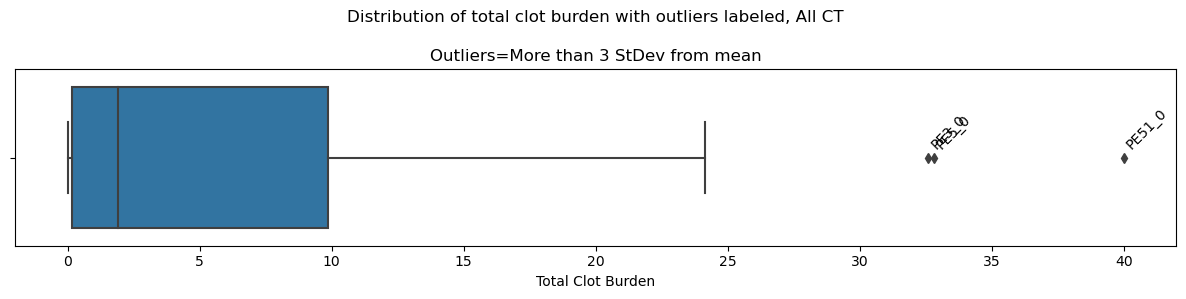

In [46]:
# Calculate z-scores for each data point
z_scores = (df.total_clot_burden - df.total_clot_burden.mean()) / df.total_clot_burden.std()
# Define a threshold for outlier detection
threshold = 3.
# Find the indices of outliers
outlier_indices = z_scores[abs(z_scores) > threshold].dropna().index
print(outlier_indices)

fig = plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='total_clot_burden')

for outlier_idx in list(outlier_indices):
    plt.annotate(
        outlier_idx,
        xy=(0, 0), xytext=(df.loc[outlier_idx, 'total_clot_burden'], -0.05), 
        textcoords='data', rotation=45
    )

plt.suptitle('Distribution of total clot burden with outliers labeled, All CT')
plt.title('Outliers=More than 3 StDev from mean')
plt.xlabel('Total Clot Burden')

plt.tight_layout()
plt.savefig('../figures/clot_burden_outliers_all.png')
plt.show()

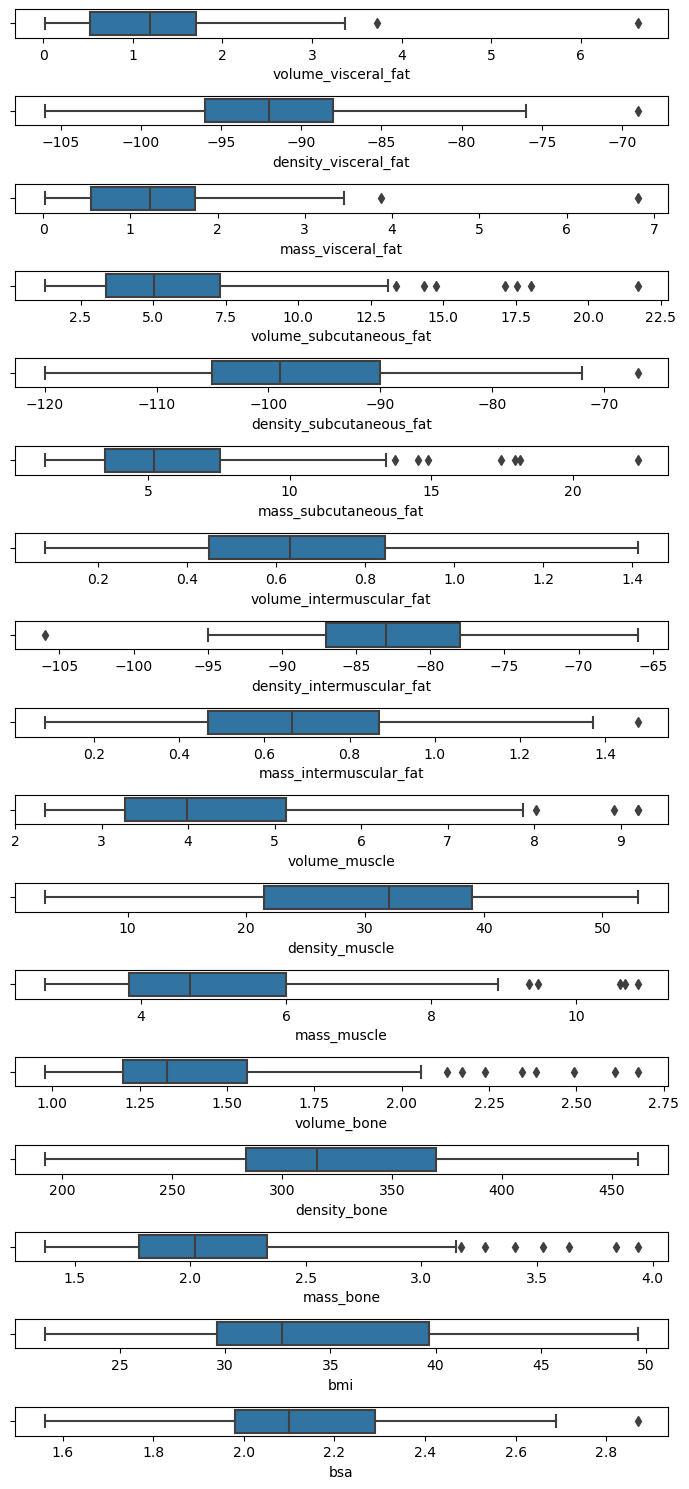

In [47]:
fig, axs = plt.subplots(len(model_config.body_feat), figsize=(7, 15))
for i, feat in enumerate(model_config.body_feat):
    sns.boxplot(data=df, x=feat, ax=axs[i])

plt.tight_layout()

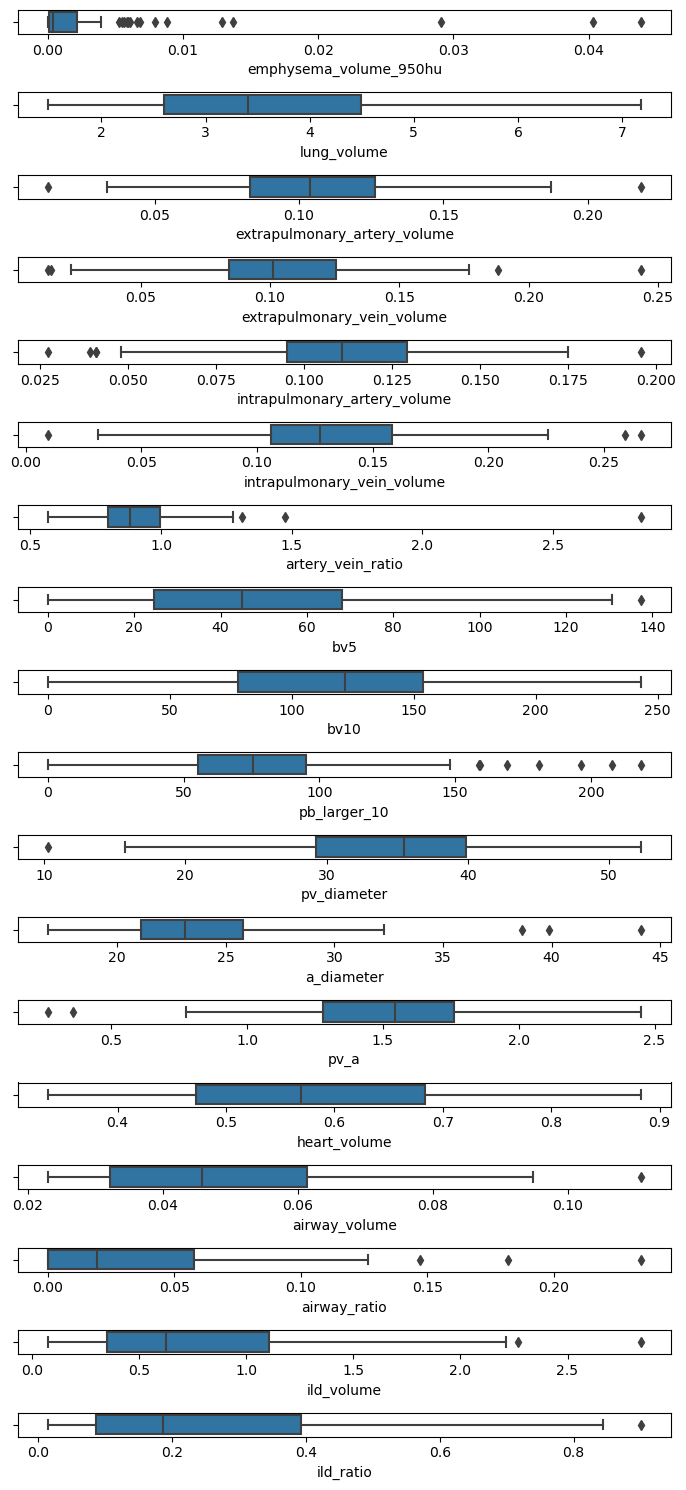

In [48]:
fig, axs = plt.subplots(len(model_config.cardiopulmonary_feat), figsize=(7, 15))
for i, feat in enumerate(model_config.cardiopulmonary_feat):
    sns.boxplot(data=df, x=feat, ax=axs[i])

plt.tight_layout()

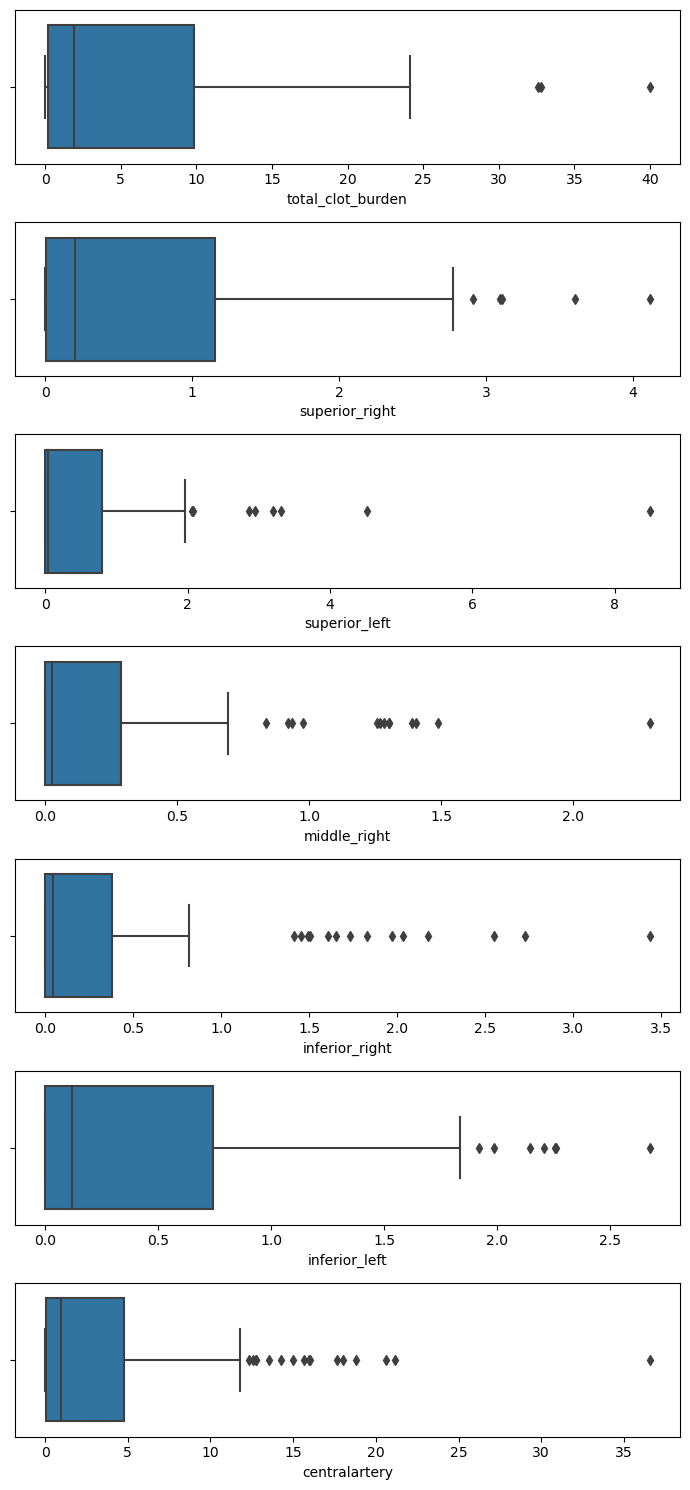

In [49]:
fig, axs = plt.subplots(len(model_config.num_targets), figsize=(7, 15))
for i, feat in enumerate(model_config.num_targets):
    sns.boxplot(data=df, x=feat, ax=axs[i])

plt.tight_layout()

In [50]:
df.resolved_pe.value_counts(dropna=False)

Unresolved    72
Resolved      25
NaN           11
Name: resolved_pe, dtype: int64

In [51]:
df[df.resolved_pe.isna()]

,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,vq_date,weight_kg
PE26_0,25.5862,NaN,0.094521,0.070832,0.149741,0.000000,0.000000,0.051738,0.000000,0.000000,...,NaN,NaN,NaN,1.16828,0.995826,3.55182,5.78621,1.648650,NaT,NaN
PE26_1,24.7424,NaN,0.092288,0.066599,0.070363,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.07550,1.017330,3.21438,5.71790,1.216950,NaT,NaN
PE26_2,24.7358,NaN,0.078614,0.065766,0.271710,0.000000,0.001474,0.038816,0.000000,0.000000,...,NaN,NaN,NaN,1.20105,0.963143,3.71662,5.23817,2.296020,NaT,NaN
PE38_0,38.6258,NaN,0.000000,0.031689,0.225305,0.000000,0.000000,0.032186,0.000000,0.039339,...,NaN,NaN,NaN,1.57943,0.992720,4.75109,17.54490,3.230860,NaT,NaN
PE38_1,26.4571,NaN,0.088429,0.065195,0.005285,0.000610,0.000000,0.028460,0.000000,0.000000,...,NaN,NaN,NaN,1.28828,0.786938,2.33919,3.11389,1.647870,NaT,NaN
PE39_0,23.2914,NaN,0.013294,0.031394,0.804879,0.316634,0.000000,0.014502,0.401231,0.274336,...,NaN,NaN,NaN,1.15078,1.097990,3.45075,14.73440,1.963430,NaT,NaN
PE46_0,24.2637,NaN,0.000000,0.055550,0.066066,0.182250,0.006834,0.013669,0.095681,0.000000,...,NaN,NaN,NaN,1.38842,1.163880,4.03817,7.20269,0.913897,NaT,NaN
PE50_0,22.8917,NaN,0.002321,0.026836,0.584393,0.009283,0.000000,0.066841,0.140180,0.000000,...,NaN,NaN,NaN,1.11998,1.051210,3.16515,4.82294,1.282520,NaT,NaN
PE50_1,21.5949,NaN,0.181686,0.045329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.25223,1.317420,4.07416,7.67940,1.320140,NaT,NaN
PE55_0,24.3141,NaN,0.013881,0.062586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.26622,0.418195,2.92905,7.11136,1.010670,NaT,NaN


In [52]:
df.loc['PE11_0', :]

a_diameter                                 NaN
age                                       37.0
airway_ratio                               NaN
airway_volume                              NaN
anterior_basal_rs8                         NaN
                                  ...         
volume_muscle                              NaN
volume_subcutaneous_fat                    NaN
volume_visceral_fat                        NaN
vq_date                    2031-02-10 00:00:00
weight_kg                                 95.6
Name: PE11_0, Length: 117, dtype: object

All of the patients with NaN values for `resolved_pe` are in the CT data but not the iCPET data.

In [53]:
# # Drop clot burden outliers
df = df.drop(index=outlier_indices)
df.shape

(105, 117)

## Export data without outliers

In [54]:
df.to_pickle(Path('../data/df_clean_no_outliers.pkl'))